In [132]:
import sys
sys.path.append('../')
from vehicle_reid.common import *
import os.path as osp
import glob
from shutil import copyfile
from matplotlib import pyplot as plt
import numpy as np

In [173]:
BBOX_DIR = '/home/hthieu/FRCNN/tf-faster-rcnn-medico/test_frcnn_out/image_train_0.6/*.txt'

In [174]:
files = glob.glob(BBOX_DIR)
files.sort()
flt = ['bus', 'truck', 'car']
best_bbox = []
unknown = 0
for file in files:
    with open(file) as fi:
        cat = []
        conf = []
        pos = []
        for line in fi:
            info = line.strip().split(' ')
            if info[0] not in flt:
                continue
            cat.append(info[0])
            conf.append(float(info[-5]))
            pos.append(info[-4:])
        
        if (len(cat) == 0):
            best_bbox.append((-1,-1,np.array([-1,-1,-1,-1])))
            unknown +=1
            continue
        cat = np.array(cat)
        conf = np.array(conf).astype(np.float32)
        pos = np.array(pos).astype(np.float32)
        area = (pos[:,2] - pos[:,0]) * (pos[:,3] - pos[:,1])
        thresh = np.max(area)*0.85
        conf = np.where(area<thresh,0, conf)
        s = np.argmax(conf)
        best_bbox.append((cat[s],conf[s],pos[s]))
print(unknown)

4047


In [175]:
imgs_lbls = np.array([x[0] for x in best_bbox])
imgs_confs = np.array([x[1] for x in best_bbox])
imgs_bboxs = np.array([x[2] for x in best_bbox])
img_paths = np.array([osp.join(IMG_DIR, osp.basename(file)).replace('.txt','.jpg') for file in files ])

In [146]:
import cv2
import os
IMG_DIR = "../../data/Track2Data/image_query/"
OUT_DIR = "../../data/Track2Data/image_query_croped"
if not (osp.exists(OUT_DIR)):
    os.makedirs(OUT_DIR)

for i, img_path in enumerate(img_paths):
    img = cv2.imread(img_path)
    x1,y1,x2,y2 = imgs_bboxs[i].astype(np.int32)
    x2 = min(x2, img.shape[1])
    y2 = min(y2, img.shape[0])
    if (x1 == -1):
        img_croped = img
    else:
        img_croped = img[y1:y2,x1:x2]
    cv2.imwrite(osp.join(OUT_DIR, osp.basename(img_path)), img_croped)

In [176]:
with open("frcnn_train.csv", "w") as fo:
    for i, img_path in enumerate(img_paths):
        fo.write("{},{},{},{}\n".format(
            osp.basename(img_path),
            best_bbox[i][0],
            best_bbox[i][1],
            best_bbox[i][2]))

117


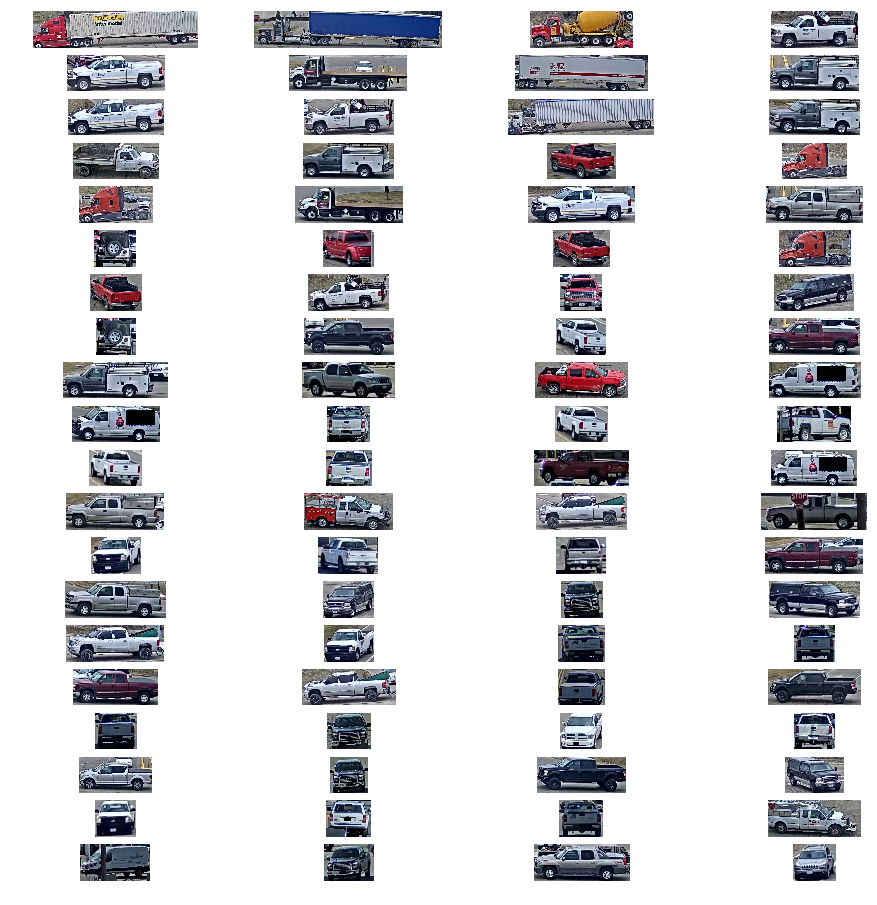

In [151]:
IMG_DIR = "../../data/Track2Data/image_query_croped/"
img_paths = np.array([osp.join(IMG_DIR, osp.basename(file)).replace('.txt','.jpg') for file in files ])
selected_imgs = np.logical_and(imgs_lbls == 'truck',imgs_confs > 0.95)
# selected_imgs = np.argsort(imgs_confs[selected_imgs])[::-1]
view_imgs = img_paths[selected_imgs]
view_conf = imgs_confs[selected_imgs]
view_imgs = view_imgs[np.argsort(view_conf)][::-1]
print(len(view_imgs))
vis_img_group(view_imgs,4,20)